In [6]:
##Importing Modules##
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
from matplotlib import gridspec
import imageio
from scipy import optimize, interpolate
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
markers = mpl.markers.MarkerStyle.filled_markers
import os
from datetime import datetime

##Formatting for matplotlib plots
mpl.rc('font',family='serif')

fsize = 23
lnwidth = 1
tickwidth = 1
msize = 7

##creating destination directory 
# labelled by the date (UK format), a small bug is that the date is only
# specific to minutes and this script can only create new scripts every minute. 
# This is sufficient for the purposes originally intended for but can easily be corrected 
# for by being more precise with the date/time used
now = datetime.now().strftime("/%d%m%y_%H%M")
out_dir = now
os.makedirs('C:\\Users\\bsukra\\repositories\\TESTING\\Image_Analysis\\analysis_notebook\\'+out_dir) ##CHANGE##

In [24]:
## functions for fitting the image to a 2D Gaussian 
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def gauss(x, *p):
    '''Typical 1D Gaussian'''
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

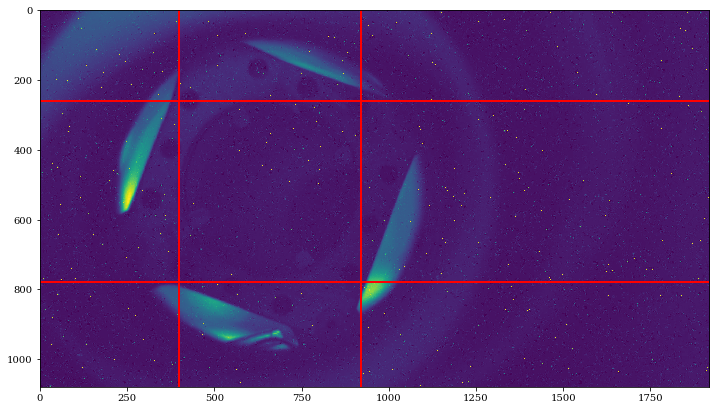

In [62]:
## Loading Background images (from saved images in 'frames' directory)
background_frames = [0,1,3,4,5]
avg_back = np.zeros((1080,1920), dtype='float32')


## Calculating an average background image
for i in np.arange(0, len(background_frames), 1):
    fname = 'frame%s.png'%(str(background_frames[i]))
    filein = os.path.join('C:\\Users\\bsukra\\repositories\\TESTING\\Image_Analysis\\analysis_notebook\\frames\\', fname) ##CHANGE##
    avg_back += imageio.imread(filein, as_gray=True)

avg_back = avg_back/len(background_frames)


## Manually locating region of interest, this could be automated when implemented
fig = plt.figure(figsize=(12,12))
plt.imshow(avg_back)
plt.axvline(400, c='r', lw=2)
plt.axvline(920, c='r', lw=2)
plt.axhline(260, c='r', lw=2)
plt.axhline(780, c='r', lw=2)

# Saving the back-image
fname = "original_image_back.png"
fileout = os.path.join('C:\\Users\\bsukra\\repositories\\TESTING\\Image_Analysis\\analysis_notebook\\'+out_dir, fname)
plt.savefig(fileout,dpi=300, bbox_inches="tight")

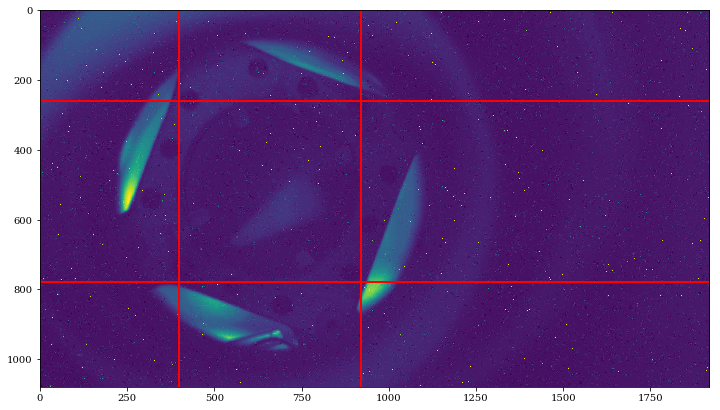

In [63]:
## Loading on-image
## this will be replaced with data acquisition real time using the cam
## N.B. the on-image is a terribly clipped e+ beam but the script still works 
fname = 'frame%s.png'%(2)
filein = os.path.join('C:\\Users\\bsukra\\repositories\\TESTING\\Image_Analysis\\analysis_notebook\\frames\\', fname) ##CHANGE##
on_image = imageio.imread(filein, as_gray=True)


## Manually locating region of interest, this could be automated when implemented
fig = plt.figure(figsize=(12,12))
plt.imshow(on_image)
plt.axvline(400, c='r', lw=2)
plt.axvline(920, c='r', lw=2)
plt.axhline(260, c='r', lw=2)
plt.axhline(780, c='r', lw=2)


# Saving the on-image
fname = "original_image_on.png"
fileout = os.path.join('C:\\Users\\bsukra\\repositories\\TESTING\\Image_Analysis\\analysis_notebook\\'+out_dir, fname)
plt.savefig(fileout,dpi=300, bbox_inches="tight")

In [30]:
## The size of the MCP+phosphor screen set-up is known to be 25 mm in diameter. The axes of original images are in pixel 
## numbers but this can be converted to mm by cropping out the area of interest
cut_avg_back = avg_back[260:780,400:920]
cut_on_image = on_image[260:780,400:920]

conv = (25./520.) ##just set to one for size in pixel numbers

In [31]:
## backsub image
cut_bsub = cut_on_image- cut_avg_back

## fitting image
params = fitgaussian(cut_bsub)
fit = gaussian(*params)
(height, x, y, width_x, width_y) = params

## determining the profiles
x_profile = cut_bsub[int(x), :]
y_profile = cut_bsub[:, int(y)]

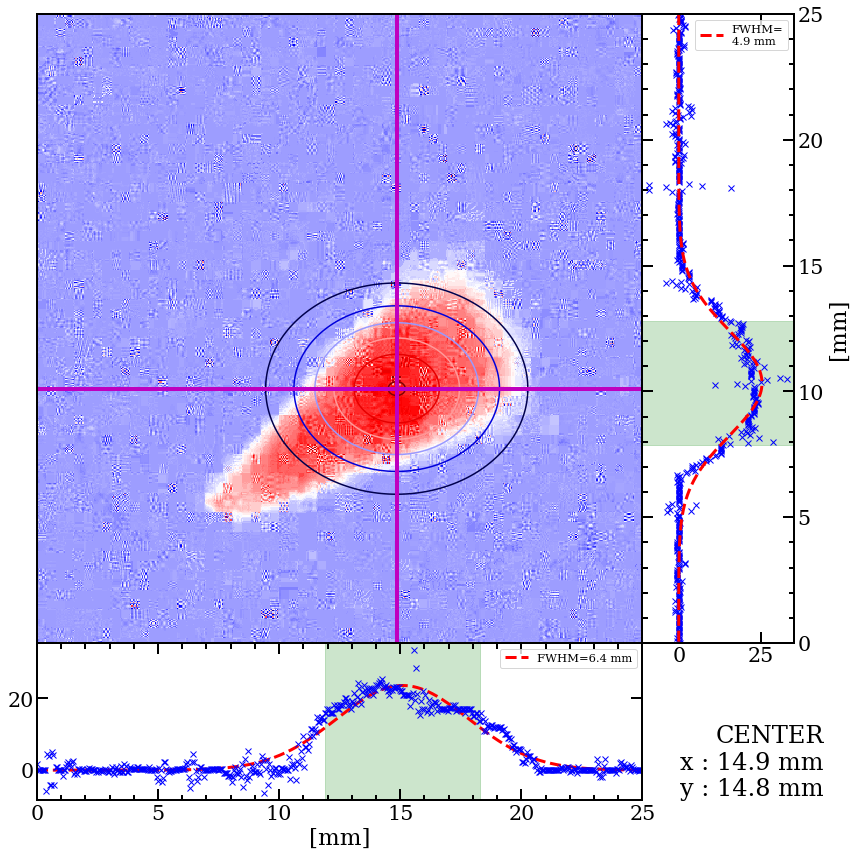

In [57]:
#############################################################################################
## MAKING IMAGE ##
#############################################################################################

## figure set-up
fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=2, nrows=2, height_ratios=(4,1), width_ratios=(4,1), wspace=0.0, hspace=0.0)


## y-PROFILE, UPPER RIGHT
ax0 = fig.add_subplot(spec[0, 1])
x = np.linspace(0,20, len(x_profile))
ys = np.linspace(0, len(y_profile), len(y_profile))
ax0.plot(y_profile[:], ys[::-1]*conv, 'bx', lw=2)




## Gaussian fit to the y-profile
p0 = [25., 300., 20.]
coeff, var_matrix = optimize.curve_fit(gauss, ys, y_profile, p0=p0)
hist_fit = gauss(ys, *coeff)
sigma = coeff[2]
FWHM = 2*np.sqrt(2*np.log(2))*sigma
plt.plot(hist_fit, ys[::-1]*conv, label=r'FWHM=''\n''%0.1f mm'%(FWHM*conv), linestyle='--', c='r', lw=3)
ax0.axhspan(len(ys)*conv-(coeff[1]-0.5*FWHM)*conv, len(ys)*conv-(coeff[1]+0.5*FWHM)*conv, color='g', alpha=0.2)


## AESTHETITCS
ax0.set_ylabel('[mm]', fontsize=fsize)
ax0.legend(loc=0, fontsize = fsize*0.5)
ax0.yaxis.set_label_position("right")
ax0.yaxis.tick_right()
ax0.set_ylim(ax0.get_ylim()[::-1])
ax0.set_ylim(0, len(y_profile)*conv)
ax0.set_aspect("auto")


## x-PROFILE, LOWER LEFT
ax1 = fig.add_subplot(spec[1, 0])
y = np.linspace(0,20, len(y_profile))
xs = np.linspace(0, len(x_profile), len(x_profile))


## Gaussian fit to the x-profile
p0 = [15., 300., 20.]
coeff, var_matrix = optimize.curve_fit(gauss, xs, x_profile, p0=p0)
hist_fit = gauss(xs, *coeff)
sigma = coeff[2]
FWHM = 2*np.sqrt(2*np.log(2))*sigma
ax1.plot(xs*conv, hist_fit, label=r'FWHM=%0.1f mm'%(FWHM*conv), linestyle='--', c='r', lw=3)
ax1.axvspan((coeff[1]-0.5*FWHM)*conv, (coeff[1]+0.5*FWHM)*conv, color='g', alpha=0.2)

## AESTHETICS
ax1.set_xlabel('[mm]', fontsize=fsize)
ax1.legend(loc=0, fontsize = fsize*0.5)
ax1.plot(xs*conv, x_profile, 'bx', lw=2)
ax1.set_xlim(0, len(x_profile)*conv)
ax1.set_aspect("auto")

# IMAGE DATA PLOT, UPPER LEFT 
ax2 = fig.add_subplot(spec[0, 0])
plt.imshow(cut_bsub, cmap='seismic')
# plt.colorbar()
plt.contour(fit(*np.indices(cut_bsub.shape)), cmap=plt.cm.seismic)
(height, x, y, width_x, width_y) = params
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_aspect("auto")




## LABELLING
plt.text(1.3, -0.25, """
CENTER
x : %.1f mm
y : %.1f mm""" %(x*conv, y*conv),
        fontsize=24, horizontalalignment='right',
        verticalalignment='bottom', transform=ax2.transAxes)



#############################################################################################
## AESTHETICS ##
#############################################################################################

################################
ax0.spines['right'].set_linewidth(lnwidth*2)
ax0.spines['top'].set_linewidth(lnwidth*2)
ax0.spines['left'].set_linewidth(lnwidth*2)
ax0.spines['bottom'].set_linewidth(lnwidth*2)
################################

################################
ax1.spines['right'].set_linewidth(lnwidth*2)
ax1.spines['top'].set_linewidth(lnwidth*2)
ax1.spines['left'].set_linewidth(lnwidth*2)
ax1.spines['bottom'].set_linewidth(lnwidth*2)
################################

################################
ax2.spines['right'].set_linewidth(lnwidth*2)
ax2.spines['top'].set_linewidth(lnwidth*2)
ax2.spines['left'].set_linewidth(lnwidth*2)
ax2.spines['bottom'].set_linewidth(lnwidth*2)
################################

################################
ax0.tick_params(axis='both', which='major', labelsize=fsize*0.9, width = tickwidth*2, length = 11, direction='in',
               top='True', bottom='True',left='True',right='True')
ax0.tick_params(axis='both', which='minor', width = tickwidth*2, length = 5.5, direction='in',
               top='True', bottom='True',left='True',right='True')
#################################

################################
ax1.tick_params(axis='both', which='major', labelsize=fsize*0.9, width = tickwidth*2, length = 11, direction='in',
               top='True', bottom='True',left='True',right='True')
ax1.tick_params(axis='both', which='minor', width = tickwidth*2, length = 5.5, direction='in',
               top='True', bottom='True',left='True',right='True')
#################################

################################
ax2.tick_params(axis='both', which='major', labelsize=fsize*0.9, width = tickwidth*2, length =0, direction='in',
               top='True', bottom='True',left='True',right='True')
ax2.tick_params(axis='both', which='minor', width = tickwidth*2, length = 0, direction='in',
               top='True', bottom='True',left='True',right='True')
#################################

################################
m0 = MultipleLocator(5)
ax0.yaxis.set_major_locator(m0)
m0 = MultipleLocator(1)
ax0.yaxis.set_minor_locator(m0)
################################

################################
m0 = MultipleLocator(5)
ax1.xaxis.set_major_locator(m0)
m0 = MultipleLocator(1)
ax1.xaxis.set_minor_locator(m0)
################################

################################
m0 = MultipleLocator(520)
ax2.xaxis.set_major_locator(m0)
# m0 = MultipleLocator(10)
# ax2.xaxis.set_minor_locator(m0)
################################

################################
m0 = MultipleLocator(520)
ax2.yaxis.set_major_locator(m0)
# m0 = MultipleLocator(10)
# ax2.yaxis.set_minor_locator(m0)
###############################

plt.axvline(y, c='m', lw=4)
plt.axhline(x, c='m', lw=4) 

fig.tight_layout()
#############################################################################################


# Saving the back-image
fname = "analysed_image_mm.png"
fileout = os.path.join('C:\\Users\\bsukra\\repositories\\TESTING\\Image_Analysis\\analysis_notebook\\'+out_dir, fname)
plt.savefig(fileout,dpi=300, bbox_inches="tight")